📓 Rainfall Prediction Model Pipeline 
This notebook documents the complete machine learning workflow, focusing on creating a robust and unbiased Random Forest Classifier. The pipeline specifically addresses common real-world challenges like data imbalance and model miscalibration to ensure accurate probability predictions.

🚀 Key Stages of the Pipeline
0. Data Exploration and Preparation (EDA)
Initial Load: Imported dataset and performed initial checks on shape, data types, and null values.

EDA: Conducted statistical and visual analysis (histograms, box plots, correlation matrix ) to understand feature distributions and relationships with the target variable (RainTomorrow).

Missing Value Handling: Applied strategies (e.g., imputation or removal) to address missing data identified during the EDA phase.

Target Encoding: Converted the categorical target variable (RainTomorrow) into numerical form (0 for No Rain, 1 for Rain) using Label Encoding.

1. Data Prep & Scaling
Balancing: Used Downsampling on the training set to resolve class imbalance (Rain vs. No Rain).

Scaling: Applied StandardScaler to normalize features, saving the scaler as scaler.pkl.

2. Optimization & Model Selection
Tuning: Used GridSearchCV with F1-Weighted Score as the primary metric to find the best Random Forest structure (best_model).

3. Critical Fix: Probability Calibration
Problem: The raw model probabilities were severely skewed (e.g., P(Rain)=0.72 for dry inputs).

Solution: Wrapped the best_model in CalibratedClassifierCV(method='isotonic') to mathematically correct the confidence scores, making the output probabilities honest.

4. Final Artifact Generation
Optimal Threshold: Used the Precision-Recall Curve method to calculate the final unbiased decision threshold (0.667) for maximum F1-Score.

Deployment Files: Saved three files: best_model_calibrated.pkl, scaler.pkl, and optimal_threshold.txt (0.667).

#Importing Essential Libraries

In [231]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy import argmax, savetxt, loadtxt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

In [232]:
df=pd.read_csv('Rainfall.csv',encoding='latin1')
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,9.3,80.0,26.3,yes
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,0.6,50.0,15.3,yes
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,0.0,40.0,14.2,yes
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,1.0,50.0,16.9,yes
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,0.0,40.0,13.7,yes


In [233]:
df.shape

(366, 12)

In [234]:
df.tail()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
361,27,1022.7,18.8,17.7,16.9,15.0,84,90,0.0,30.0,18.4,yes
362,28,1026.6,18.6,17.3,16.3,12.8,75,85,1.0,20.0,25.9,yes
363,29,1025.9,18.9,17.7,16.4,13.3,75,78,4.6,70.0,33.4,yes
364,30,1025.3,19.2,17.3,15.2,13.3,78,86,1.2,20.0,20.9,yes
365,31,1026.4,20.5,17.8,15.5,13.0,74,66,5.7,20.0,23.3,no


In [235]:
df.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,365.000000,365.000000
mean,15.756831,1013.742623,26.191257,23.747268,21.894536,19.989071,80.177596,71.128415,4.419399,101.506849,21.536986
std,8.823592,6.414776,5.978343,5.632813,5.594153,5.997021,10.062470,21.798012,3.934398,81.723724,10.069712
min,1.000000,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,10.000000,4.400000
25%,8.000000,1008.500000,21.200000,18.825000,17.125000,16.125000,75.000000,58.000000,0.500000,40.000000,13.700000
50%,16.000000,1013.000000,27.750000,25.450000,23.700000,21.950000,80.500000,80.000000,3.500000,70.000000,20.500000
75%,23.000000,1018.100000,31.200000,28.600000,26.575000,25.000000,87.000000,88.000000,8.200000,190.000000,27.900000
max,31.000000,1034.600000,36.300000,32.400000,30.000000,26.700000,98.000000,100.000000,12.100000,350.000000,59.500000


In [236]:
df['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   sunshine                366 non-null    float64
 9            winddirection  365 non-null    float64
 10  windspeed               365 non-null    float64
 11  rainfall                366 non-null    object 
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


#Removing Extra Space 

In [238]:
df.columns=df.columns.str.strip()

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int64  
 1   pressure       366 non-null    float64
 2   maxtemp        366 non-null    float64
 3   temparature    366 non-null    float64
 4   mintemp        366 non-null    float64
 5   dewpoint       366 non-null    float64
 6   humidity       366 non-null    int64  
 7   cloud          366 non-null    int64  
 8   sunshine       366 non-null    float64
 9   winddirection  365 non-null    float64
 10  windspeed      365 non-null    float64
 11  rainfall       366 non-null    object 
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [240]:
df.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

#Dropping irrelevant column

In [241]:
df.drop(['day'],axis=1,inplace=True)

In [242]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1025.9,19.9,18.3,16.8,13.1,72,49,9.3,80.0,26.3,yes
1,1022.0,21.7,18.9,17.2,15.6,81,83,0.6,50.0,15.3,yes
2,1019.7,20.3,19.3,18.0,18.4,95,91,0.0,40.0,14.2,yes
3,1018.9,22.3,20.6,19.1,18.8,90,88,1.0,50.0,16.9,yes
4,1015.9,21.3,20.7,20.2,19.9,95,81,0.0,40.0,13.7,yes


#Handling null values

In [243]:
print(df.isnull().sum())

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        1
rainfall         0
dtype: int64


In [244]:
df['windspeed']=df['windspeed'].fillna(df['windspeed'].median())
df['winddirection']=df['winddirection'].fillna(df['winddirection'].mode()[0])

In [245]:
print(df.isnull().sum())

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64


In [246]:
print(df.duplicated().sum())

0


In [247]:
df['rainfall'].value_counts()

rainfall
yes    249
no     117
Name: count, dtype: int64

#Exploratory Data Analysis

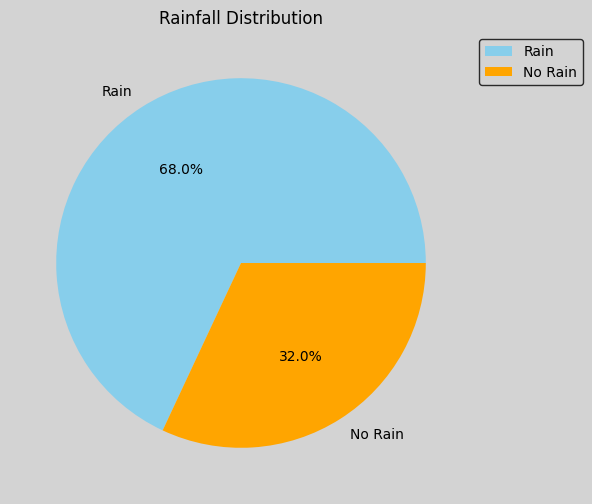

In [248]:
plt.figure(figsize=(10,6),facecolor='lightgrey')
plt.pie(df['rainfall'].value_counts(),autopct='%1.1f%%',labels=['Rain','No Rain'],colors=['skyblue','orange'])
plt.title('Rainfall Distribution')
plt.legend(facecolor='lightgrey',edgecolor='black',bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [249]:
corr=df.corr(numeric_only=True)
corr

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
pressure,1.000000,-0.829088,-0.851780,-0.839851,-0.860232,-0.274907,0.005621,-0.198171,-0.656828,0.373587
maxtemp,-0.829088,1.000000,0.986193,0.961534,0.899829,0.021882,-0.289765,0.507416,0.625447,-0.442095
temparature,-0.851780,0.986193,1.000000,0.990187,0.936866,0.092030,-0.205895,0.420545,0.645266,-0.393619
mintemp,-0.839851,0.961534,0.990187,1.000000,0.944515,0.139040,-0.156097,0.368288,0.629738,-0.359013
dewpoint,-0.860232,0.899829,0.936866,0.944515,1.000000,0.425282,0.044635,0.185234,0.623952,-0.378227
humidity,-0.274907,0.021882,0.092030,0.139040,0.425282,1.000000,0.655493,-0.563579,0.099471,-0.076740
cloud,0.005621,-0.289765,-0.205895,-0.156097,0.044635,0.655493,1.000000,-0.848334,-0.077037,0.258248
sunshine,-0.198171,0.507416,0.420545,0.368288,0.185234,-0.563579,-0.848334,1.000000,0.251374,-0.298922
winddirection,-0.656828,0.625447,0.645266,0.629738,0.623952,0.099471,-0.077037,0.251374,1.000000,-0.219379
windspeed,0.373587,-0.442095,-0.393619,-0.359013,-0.378227,-0.076740,0.258248,-0.298922,-0.219379,1.000000


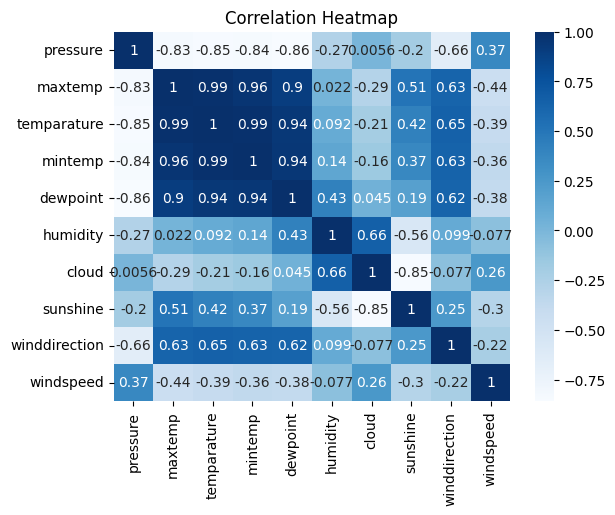

In [250]:
sns.heatmap(corr,annot=True,cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

In [251]:
df.columns

Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall'],
      dtype='object')

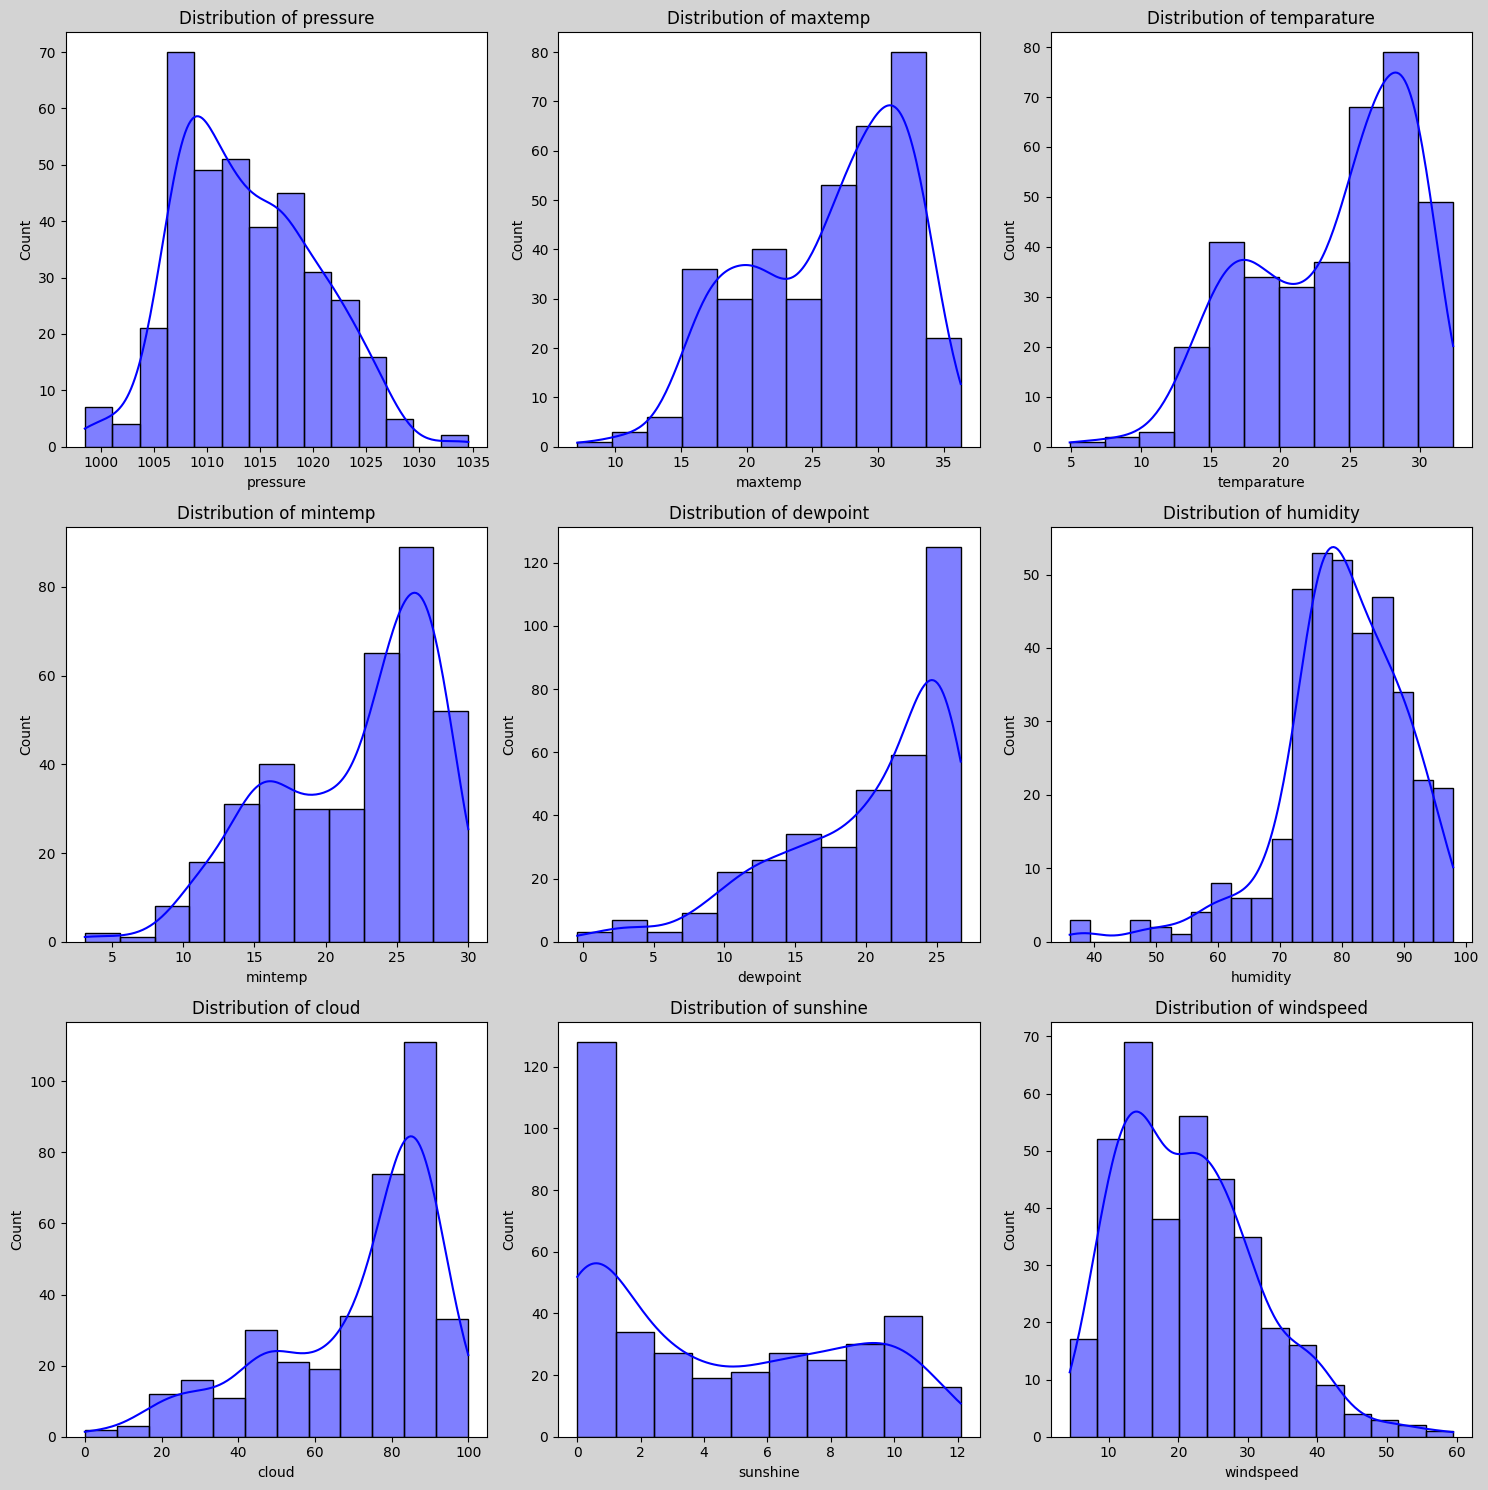

In [252]:
plt.figure(figsize=(15,15),facecolor='lightgrey')
for i , index in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine','windspeed']):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[index], kde=True, color='blue')
    plt.title(f'Distribution of {index}')
plt.tight_layout()
plt.show()

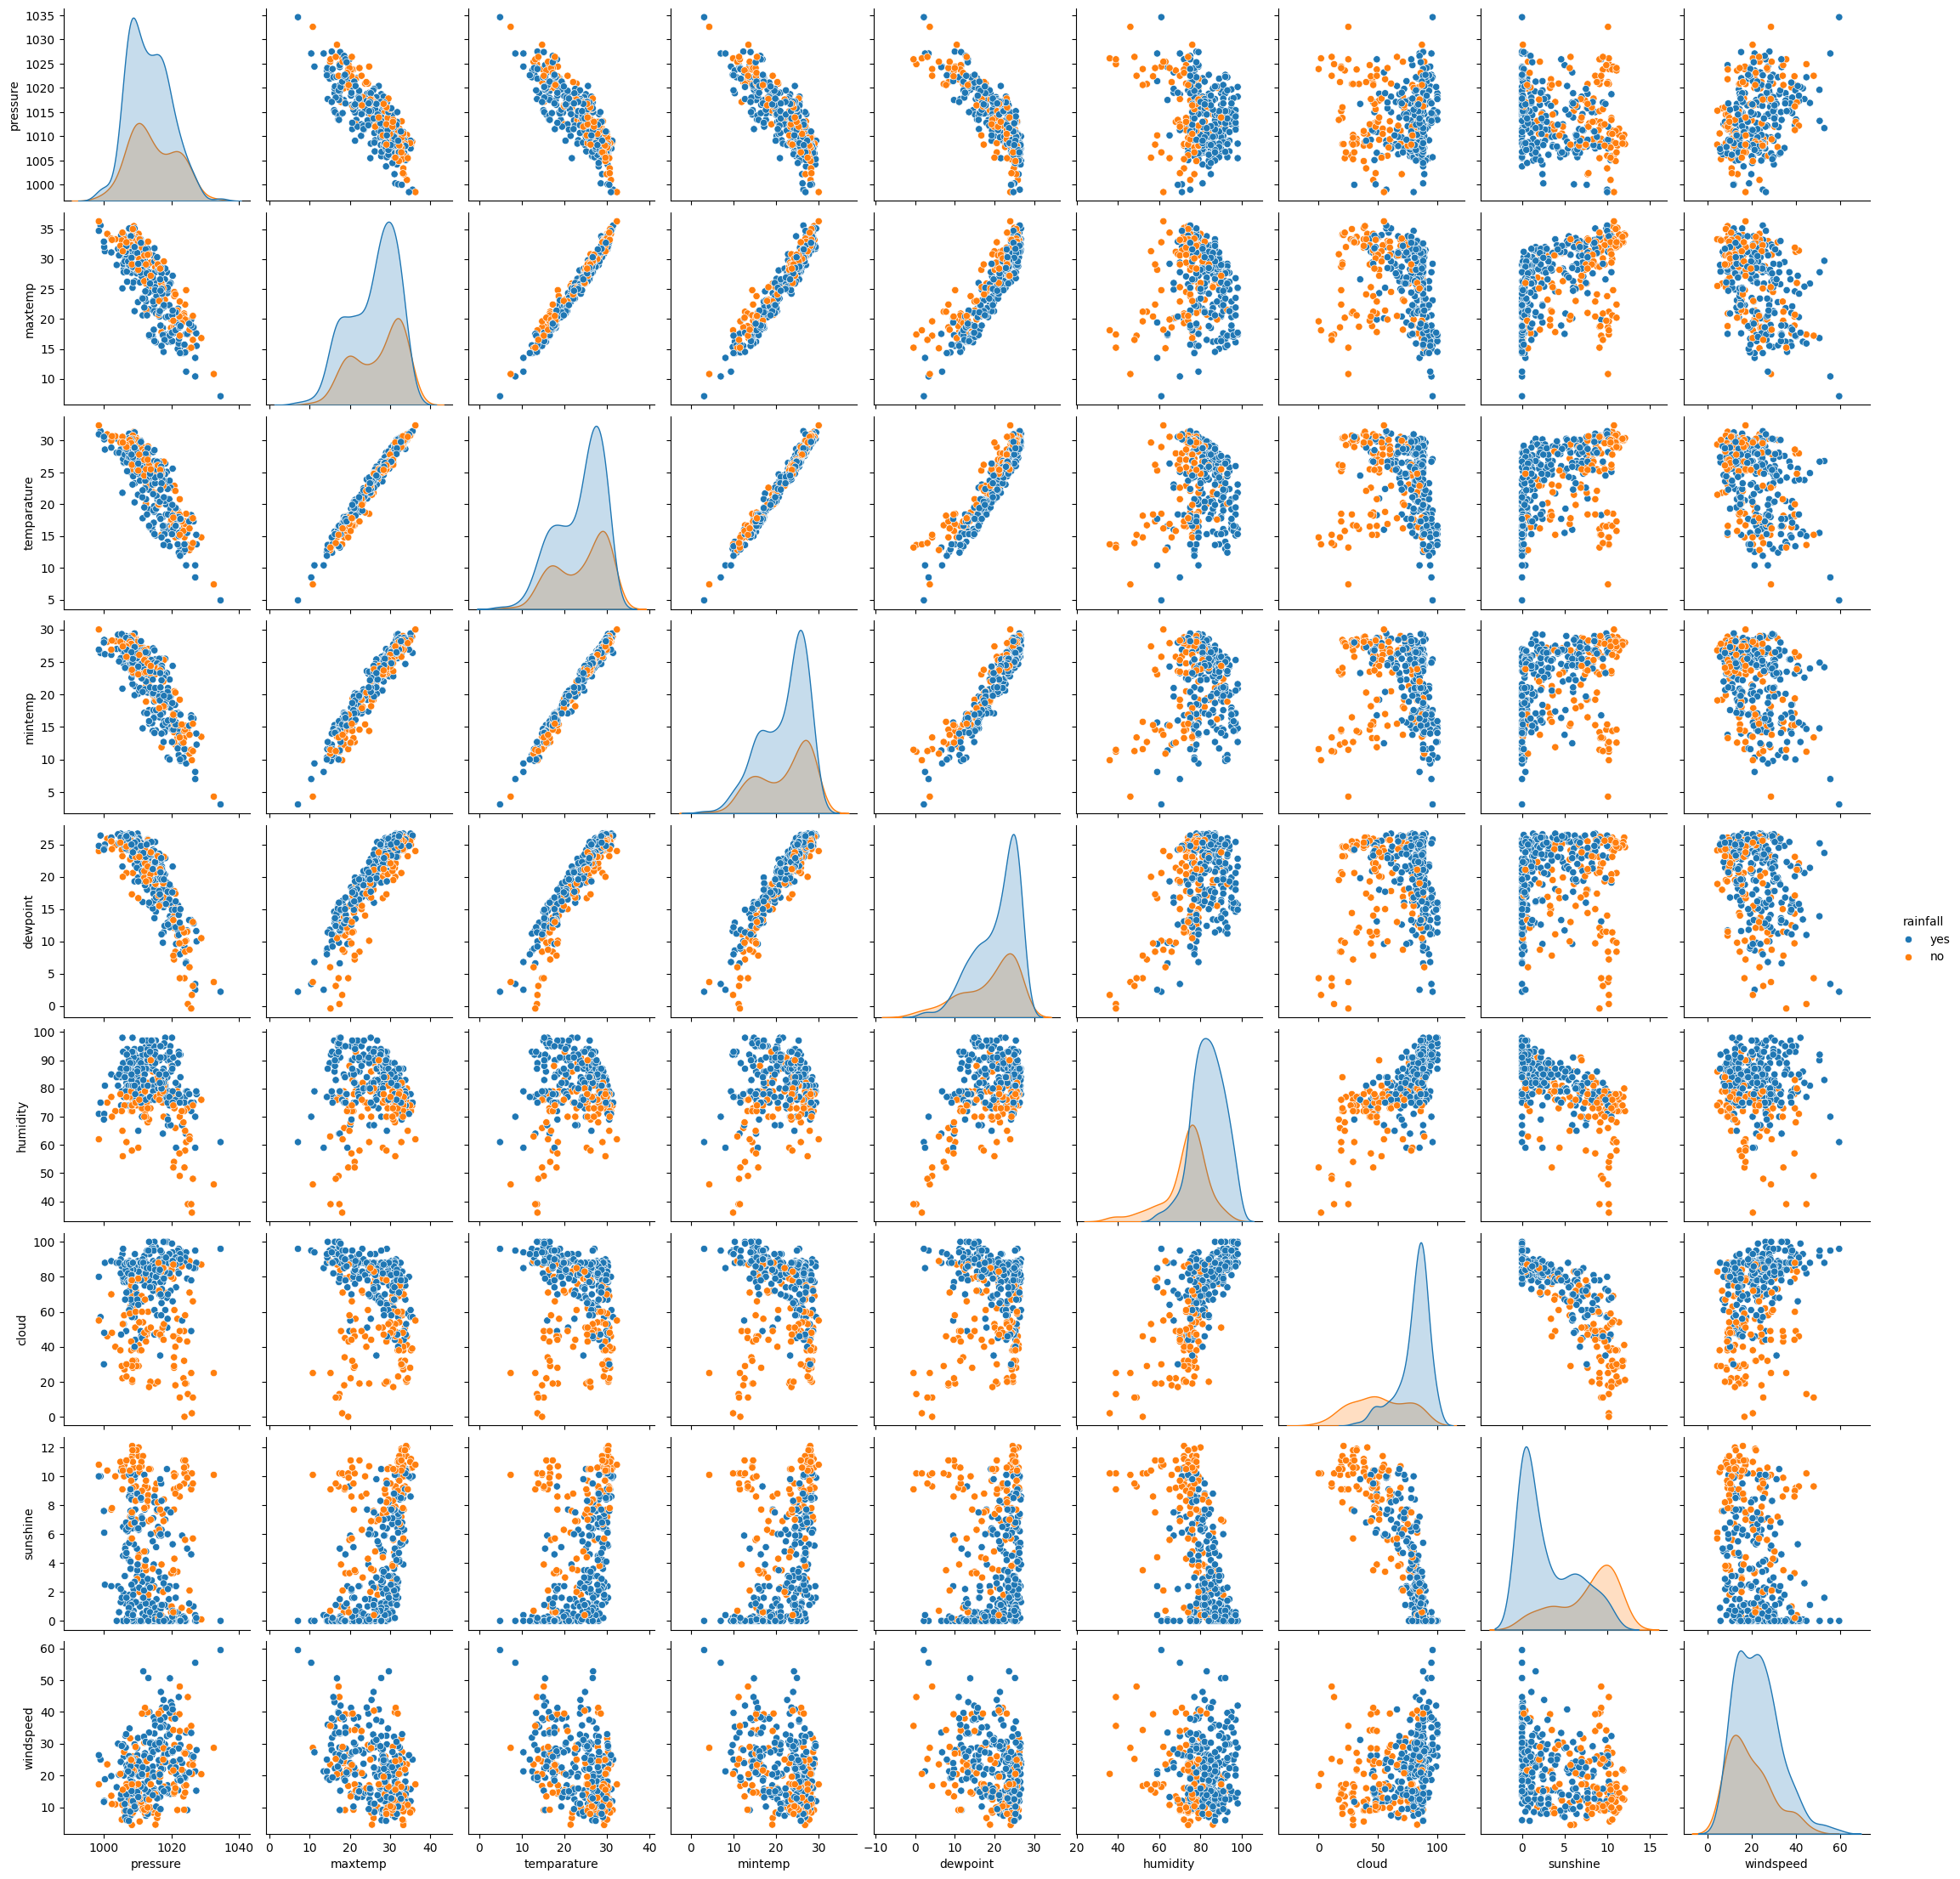

In [253]:
sns.pairplot(df,vars=['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine','windspeed'],hue='rainfall')
plt.show()

#Feature Engineering 

In [254]:
le=LabelEncoder()
df['rainfall']= le.fit_transform(df['rainfall'])


In [255]:
df['rainfall'].value_counts()

rainfall
1    249
0    117
Name: count, dtype: int64

In [256]:
df.columns

Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall'],
      dtype='object')

In [257]:
X=df.drop(['rainfall','maxtemp', 'temparature', 'mintemp'],axis=1)
y=df['rainfall']

#Splitting Dataset

In [258]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [259]:
print(X_train)
print(y_train)

     pressure  dewpoint  humidity  cloud  sunshine  winddirection  windspeed
341    1023.1      12.1        72     86       0.9           10.0       21.8
202    1010.9      25.3        76     49       8.8          220.0       12.3
75     1015.0      13.6        90    100       0.0           60.0       33.2
84     1023.9       9.2        75     88       0.2           20.0       19.4
354    1022.5      12.9        75     88       0.0           40.0       19.0
..        ...       ...       ...    ...       ...            ...        ...
71     1017.7      11.4        87    100       0.0           50.0       36.0
106    1010.5      22.7        89     81       3.5          210.0       15.3
270    1008.2      25.0        85     81       2.5           90.0       15.1
348    1016.6      17.3        82     84       0.4           50.0       20.3
102    1009.1      19.3        94     88       0.0           70.0       29.8

[292 rows x 7 columns]
341    0
202    1
75     1
84     1
354    1
      .

#Downsampling Data 

In [260]:
X_majority=X_train[y_train==1]
X_minority=X_train[y_train==0]
y_majority=y_train[y_train==1]
y_minority=y_train[y_train==0]  

In [261]:
X_train_sampled= resample(X_majority,replace=True,n_samples=len(X_minority),random_state=42)
y_train_sampled= resample(y_majority,replace=True,n_samples=len(y_minority),random_state=42)    

In [262]:
X_train_balanced = pd.concat([X_train_sampled, X_minority])
y_train_balanced = pd.concat([y_train_sampled, y_minority])

In [263]:
#shuffle the dataset
X_train_final = X_train_balanced.sample(frac=1, random_state=42)
y_train_final = y_train_balanced.sample(frac=1, random_state=42)

In [264]:
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train_final)

In [265]:
import joblib
joblib.dump(sc,'scaler.pkl')

['scaler.pkl']

#Finding best model

In [266]:
model_params={
    'LogisticRegression':{
        'model': LogisticRegression(),
        'params':{
            'C':[0.1,1,10],
            'solver':['liblinear','lbfgs'],
            'class_weight':[None,'balanced']
        }
    },
    'KNeighborsClassifier':{
        'model': KNeighborsClassifier(),
        'params':{
            'n_neighbors':[3,5,7],
            'weights':['uniform','distance']
        }
    },
    'DecisionTreeClassifier':{
        'model': DecisionTreeClassifier(),
        'params':{
            'max_depth':[None,5,10],
            'min_samples_split':[2,5,10],
            'class_weight':[None,'balanced']
        }
    },
    'RandomForestClassifier':{
        'model': RandomForestClassifier(),
        'params':{
            'n_estimators':[100,200],
            'max_features':['sqrt'],
            'random_state':[42],
            
        }
    }
}

In [277]:
results=[]
for i in model_params:
    gs=GridSearchCV(model_params[i]['model'],model_params[i]['params'],cv=5,return_train_score=False,n_jobs=-1,scoring='f1_weighted')
    gs.fit(X_train_scaled,y_train_final)
    results.append({
        'model':i,
        'best_score':gs.best_score_,
        'best_params':gs.best_params_
    })  
results_df=pd.DataFrame(results,columns=['model','best_score','best_params'])
results_df.sort_values(by='best_score',ascending=False)

,model,best_score,best_params
3,RandomForestClassifier,0.854648,"{'max_features': 'sqrt', 'n_estimators': 100, ..."
1,KNeighborsClassifier,0.822211,"{'n_neighbors': 7, 'weights': 'distance'}"
2,DecisionTreeClassifier,0.804884,"{'class_weight': 'balanced', 'max_depth': 10, ..."
0,LogisticRegression,0.785156,"{'C': 0.1, 'class_weight': None, 'solver': 'li..."


In [279]:
rc = RandomForestClassifier(n_estimators=200,  max_features='sqrt',random_state=42)
rc.fit(X_train_final, y_train_final)
y_pred = rc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.74      0.60        23
           1       0.85      0.67      0.75        51

    accuracy                           0.69        74
   macro avg       0.68      0.70      0.67        74
weighted avg       0.74      0.69      0.70        74



In [269]:
best_model=gs.best_estimator_
print(best_model)

RandomForestClassifier(random_state=42)


#Calibrating Best Model

In [ ]:
calibrated_model = CalibratedClassifierCV(
    best_model, 
    method='isotonic', 
    cv=5 
)

calibrated_model.fit(X_train_scaled, y_train_final) 

,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


#Generating Custom Threshold 

In [ ]:
y_probs_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_calibrated)
fscores = (2 * precision * recall) / (precision + recall + 1e-6) 
ix = argmax(fscores)
new_optimal_threshold = thresholds[ix] if ix < len(thresholds) else thresholds[-1] 

print(f"New Optimal Threshold (Max F1, Calibrated Model): {new_optimal_threshold:.3f}")

New Optimal Threshold (Max F1, Calibrated Model): 0.667


C:\Users\sujal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\sujal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\sujal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\sujal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\sujal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted with

In [272]:
import joblib
joblib.dump(calibrated_model, 'best_model_calibrated.pkl')

['best_model_calibrated.pkl']